In [13]:
import logging

import astropy.io.ascii as at
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib import colors
import photutils
from photutils.datasets import make_4gaussians_image
from photutils.morphology import centroid_com, centroid_1dg, centroid_2dg
from photutils.morphology import data_properties
from photutils import properties_table, EllipticalAperture
from astropy.stats import sigma_clipped_stats

from k2spin import lc
from k2spin import k2io
from k2spin import plot
from k2phot import tpf_io
from k2phot import centroid
from k2phot import phot


## Circular apertures for nearby stars

Elliptical apertures are probably too complex to try for nearby stars. I'd have to clip them from each other using some algorithm, then fit the ellipse within that clipped box. Way too much margin for error.

Therefore, let's try computing circular apertures for a pair of nearby stars. The radius of their apertures should be half the distance between them (which works in this case because they're similar in brightness and separated by a few pixels)

First just coadd the images and find all the sources, then compute the separation between our two sources of interest and determine the appropriate aperture size. 

Note that automating this will be challenging, because here I know that if there are 3 sources, the first 2 are my relevant stars, but for the full operation I'd need to check the positions at every step.

Now make a lightcurve. This is the basically same procedure as in k2phot.phot, except it's generating a lightcurve for both sources instead of just one. 

Plot the centroid coordinates over the coadded image.

In [18]:
double_figure = (13,6)

def run_one(filename, aps=None):
    
    epic=filename.split("/")[-1][4:13]
    table, times, pixels, maskmap, maskheader, kpmag = tpf_io.get_data(filename)
    coadd = np.sum(pixels, axis=0)
    cmask = (maskmap==0)
    mean, median, std = sigma_clipped_stats(coadd, mask=cmask, sigma=3.0, iters=3)
    print median
    
    init = centroid.init_pos(maskheader)
#    coords = centroid.flux_weighted_centroid(coadd, 9, init=init)
#    coadd_bkgd = phot.calc_bkgd(coadd, maskmap, coords[:2], 2)
    sources, ninit = centroid.daofind_centroid(coadd, 
                                               daofind_kwargs={"threshold":median,
                                                               "fwhm":2.5,
                                                               "sharphi":5,
                                                               "sharplo":0.01})
    print sources

    plt.matshow(coadd, origin='lower', cmap='Greys_r', norm=colors.LogNorm())
    positions = np.array([[source["xcentroid"], source["ycentroid"]] 
                          for source in sources])

    if (ninit==1):
        sep = np.sqrt((sources[0]["ycentroid"] - init[1])**2 + 
                      (sources[0]["xcentroid"] - init[0])**2)
        if sep<3:
            return
        else:
            ninit=2
            positions = np.array([[init[0],init[1]],
                                 [sources[0]["xcentroid"], sources[0]["ycentroid"]]])
    else:
        sep = np.sqrt((sources[0]["ycentroid"] - sources[1]["ycentroid"])**2 + 
                      (sources[0]["xcentroid"] - sources[1]["xcentroid"])**2)
    r = sep / 2.0
    apertures = photutils.CircularAperture(positions, r=r)
    init_positions = positions    
    
    all_time = np.zeros(len(pixels)*(ninit+1))
    all_flux = np.zeros(len(pixels)*(ninit+1))
    all_x = np.zeros(len(pixels)*(ninit+1))
    all_y = np.zeros(len(pixels)*(ninit+1))
    all_count = 0
    
    for i, p in enumerate(pixels):
        mean, median, std = sigma_clipped_stats(p, mask=cmask, sigma=3.0, iters=3)
        sources, n = centroid.daofind_centroid(p,
                        daofind_kwargs={"threshold":median, "fwhm":2.5})
        #if n!=ninit:
        if n==0:
            continue

        positions = np.array([[source["xcentroid"], source["ycentroid"]] 
                              for source in sources])
        apertures = photutils.CircularAperture(positions, r=2)
        phot_table = photutils.aperture_photometry(p - median, apertures)
        for j, source in enumerate(sources):
            all_time[all_count] = times[i]
            all_flux[all_count] = phot_table["aperture_sum"][j]
            all_x[all_count] = source["xcentroid"]
            all_y[all_count] = source["ycentroid"]
            all_count += 1

    all_sep1 = np.sqrt((all_x - init_positions[0,0])**2 +
                       (all_y - init_positions[0,1])**2)
    loc1 = np.where(all_sep1<2)[0]
    flux1 = all_flux[loc1]
    pos1 = np.array([[all_x[i], all_y[i]] for i in loc1])
    times1 = all_time[loc1]
    
    all_sep2 = np.sqrt((all_x - init_positions[1,0])**2 +
                       (all_y - init_positions[1,1])**2)
    loc2 = np.where(all_sep2<2)[0]
    flux2 = all_flux[loc2]
    pos2 = np.array([[all_x[i], all_y[i]] for i in loc2])
    times2 = all_time[loc2]


    np.where(flux1>0)[0]
    good1 = np.where((pos1[:,0]>0) & (pos1[:,1]>0))[0]
    good2 = np.where((pos2[:,0]>0) & (pos2[:,1]>0))[0]

    lc1 = lc.LightCurve(times1[good1], flux1[good1], np.ones_like(flux1[good1])*0.01,
                        pos1[:,0][good1], pos1[:,1][good1], name="ktwo{0}A".format(epic), 
                        detrend_kwargs={"kind":"supersmoother","phaser":10})
    lc2 = lc.LightCurve(times2[good2], flux2[good2], np.ones_like(flux2[good2])*0.01, 
                        pos2[:,0][good2], pos2[:,1][good2], name="ktwo{0}B".format(epic),
                        detrend_kwargs={"kind":"supersmoother","phaser":10})
 
    lc1.choose_initial()
    lc1.correct_and_fit()
 
    lc2.choose_initial()
    lc2.correct_and_fit()

    # Write out light curves
    colnames = ["i","t","x","y","flux_2.0"]
    tab1 = {"i":np.arange(len(good1)),"t":times1[good1], "x": pos1[:,0][good1],
             "y": pos1[:,1][good1],"flux_2.0":flux1[good1]}
    at.write(tab1, "lcs/ktwo{0}0-c04.csv".format(epic), names=colnames)
    tab2 = {"i":np.arange(len(good2)),"t":times2[good2], "x": pos2[:,0][good2],
             "y": pos2[:,1][good2],"flux_2.0":flux2[good2]}
    at.write(tab2, "lcs/ktwo{0}1-c04.csv".format(epic), names=colnames)
    
    # Plot apertures and positions
    
    fig = plt.figure(figsize=double_figure)
    ax_stamp = plt.subplot2grid((2,3),(0,0),rowspan=2)
    ax1 = plt.subplot2grid((2,3),(0,1),colspan=2)
    ax2 = plt.subplot2grid((2,3),(1,1),colspan=2)

    
    divider3 = make_axes_locatable(ax_stamp)
    cax = divider3.append_axes("bottom", size="5%", pad=0.35)
    # ^^^ NOT WORKING RIGHT

    ax_stamp.matshow(coadd, origin='lower', cmap='Greys_r', norm=colors.LogNorm())
    r = sep / 2.0
#    apertures = photutils.CircularAperture(init_positions, r=r)
#    apertures.plot(color='red')
#    ax_stamp.plot(init_positions[:,0], init_positions[:,1], 'gD')

    f1 = plt.Circle(init_positions[0], 2, color="r", fill=False, linewidth=2)
    f2 = plt.Circle(init_positions[1], 2, color="r", fill=False, linewidth=2)
    ax_stamp.add_artist(f1)
    ax_stamp.add_artist(f2)

    ax_stamp.set_xlim(-0.5,maskmap.shape[1]-0.5)
    ax_stamp.set_ylim(-0.5,maskmap.shape[0]-0.5)
    plt.savefig("plot_outputs_companions/ktwo{0}_paper0.png".format(epic))
        
    xyt1 = ax_stamp.scatter(pos1[:,0][good1], pos1[:,1][good1], c=times1[good1],  
                          edgecolor="none", alpha=0.5,  
                          vmin=np.percentile(times1[good1], 5), 
                          vmax=np.percentile(times1[good1], 95),
                          cmap="gnuplot")
    xyt = ax_stamp.scatter(pos2[:,0][good2], pos2[:,1][good2], c=times2[good2],  
                          edgecolor="none", alpha=0.5,  
                          vmin=np.percentile(times2[good2], 5), 
                          vmax=np.percentile(times2[good2], 95),
                          cmap="gnuplot")
    cbar_ticks = np.asarray(np.percentile(times2[good2],np.arange(10,100,20)),int)
    cbar1 = fig.colorbar(xyt, cax=cax, ticks=cbar_ticks, orientation="horizontal")
    cbar1.set_label("Time (d)",fontsize="x-large")
    ax_stamp.tick_params(labelsize="x-large")
    ax_stamp.set_ylabel("Y",fontsize="xx-large")
    ax_stamp.set_xlabel("X",fontsize="xx-large")

    ax2.plot(times1[good1], flux1[good1]/np.median(flux1[good1]), 'k.',label="Raw")
    ax1.plot(times2[good2], flux2[good2]/np.median(flux2[good2]), 'k.',label="Raw")
        
    ax2.plot(lc1.time, lc1.corrected_flux, '.', color='SlateBlue', label="Corrected")
    ax1.plot(lc2.time, lc2.corrected_flux, '.', color='SlateBlue', label="Corrected")
    ax1.tick_params(labelsize="x-large",labelleft=False,labelright=True,labelbottom=False)
    ax2.tick_params(labelsize="x-large",labelleft=False,labelright=True)
    
    ax1.set_xticklabels([])
    ax2.set_xlabel("Time (d)",fontsize="xx-large")
    ax1.set_ylabel("Flux (target)",fontsize="xx-large")
    ax2.set_ylabel("Flux (neighbor)",fontsize="xx-large")
    ax1.set_xlim(2230)
    ax2.set_xlim(2230)
    ax1.set_ylim(0.94,1.06)
    ax2.set_ylim(0.94,1.06)
    
    leg = ax1.legend(loc='best',numpoints=3,borderaxespad=0,handletextpad=0.2)
    leg.get_frame().set_alpha(1)

    #plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0.2)
    plt.savefig("plot_outputs_companions/ktwo{0}_paper.png".format(epic),bbox_inches="tight")
    plt.savefig("/home/stephanie/my_papers/hyadesk2/ktwo{0}_paper.eps".format(epic),bbox_inches="tight")

    zero_loc = np.where((all_x<0.5) & (all_y<0.5))[0]
    to_remove = np.append(np.append(loc1, loc2), zero_loc)
    other_x = np.delete(all_x, to_remove)
    other_y = np.delete(all_y, to_remove)
    other_flux = np.delete(all_flux, to_remove)
    other_time = np.delete(all_time, to_remove)
    
    if len(other_flux)>100:
        plt.figure(figsize=(11,5))
        ax = plt.subplot(311)
        ax.plot(other_time, other_flux, 'm.')
        ax.set_ylabel("flux")
        ax = plt.subplot(312)
        ax.plot(other_time, other_x, 'm.')
        ax.set_ylabel("X")
        ax = plt.subplot(313)
        ax.plot(other_time, other_y, 'm.')
        ax.set_ylabel("Y")
        ax.set_xlabel("time (d)")
        plt.savefig("plot_outputs_companions/ktwo{0}_other.png".format(epic))


1.35185e+06
 id   xcentroid     ycentroid   ...    peak         flux          mag      
--- ------------- ------------- ... ---------- ------------- --------------
  1 2.39047560232 5.06060472154 ... 98908384.0 61.2465410654 -4.46770391673
  2 6.56816234683  6.1789802587 ... 22846750.0 12.8641848351 -2.77345567869


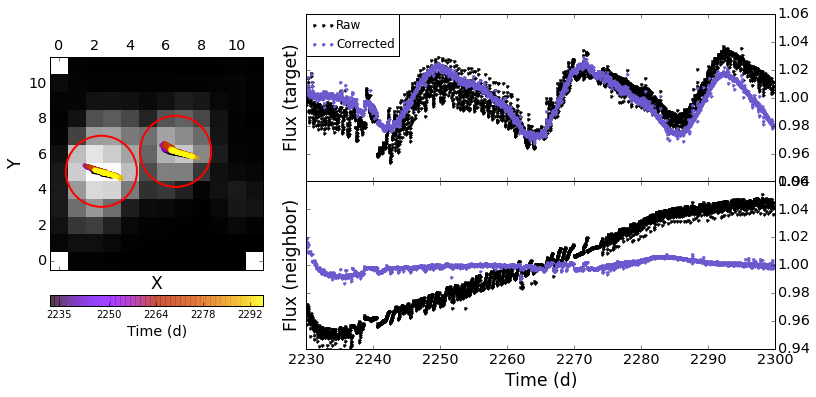

In [20]:
filename = "/home/stephanie/Dropbox/c4_tpf/ktwo210736105-c04_lpd-targ.fits"
run_one(filename)
# These PSFs overlap, and the neighbor is brighter than the target. 
# A 2-pixel aperture would isolate the main star, though not its entire PSF
# And the flux-weighted centroid is definitely biased towards the neighbor
# So this one is worth putting work into the extraction

In [ ]:
filename = "/home/stephanie/Dropbox/c4_tpf_extra/ktwo210742017-c04_lpd-targ.fits"
run_one(filename)
# These PSFs overlap, and the neighbor is brighter than the target. 
# A 2-pixel aperture would isolate the main star, though not its entire PSF
# And the flux-weighted centroid is definitely biased towards the neighbor
# So this one is worth putting work into the extraction

1.5291e+06
 id   xcentroid     ycentroid   ...     peak         flux          mag      
--- ------------- ------------- ... ----------- ------------- --------------
  1 2.97019009764 2.98612560253 ... 112553152.0 58.4924291637 -4.41774914447
  2 5.68859011461 5.35957813635 ...  24379650.0 13.2909512344 -2.80889016136


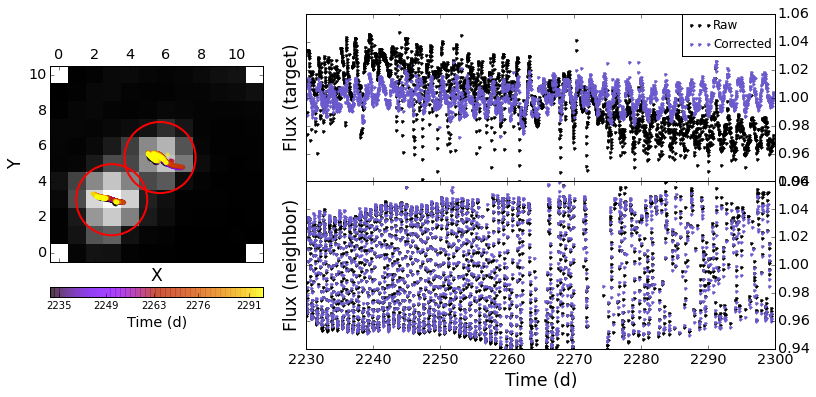

In [19]:
filename = "/home/stephanie/Dropbox/c4_tpf_extra/ktwo210963067-c04_lpd-targ.fits"
run_one(filename)
# These PSFs overlap, and the neighbor is brighter than the target. 
# A 2-pixel aperture would isolate the main star, though not its entire PSF
# And the flux-weighted centroid is definitely biased towards the neighbor
# So this one is worth putting work into the extraction